In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
from random import random
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import kurtosis
from ast import literal_eval
import seaborn as sns
from ast import literal_eval
from sklearn.metrics import *
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import scipy
from sklearn.metrics import *
import torch

# Optional imports

In [2]:
%%capture
!pip install --upgrade --no-cache-dir gdown

In [3]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertModel

In [4]:
%%capture
model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def bert_encode(t):
  input_ids = bert_tokenizer.encode(t)
  #print(bert_tokenizer.convert_ids_to_tokens(input_ids))
  outputs = bert_model(torch.tensor([input_ids]))[0]
  return outputs[0,0].tolist()

In [5]:
df=pd.read_pickle("attitudes_embedded.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              626 non-null    object
 1   toyou              626 non-null    object
 2   toany              626 non-null    object
 3   annotatorMinority  626 non-null    object
 4   bert               626 non-null    object
 5   annotatorPolitics  626 non-null    object
 6   traditionalism     626 non-null    object
 7   annotatorRace      626 non-null    object
 8   annotatorAge       626 non-null    object
 9   annotatorGender    626 non-null    object
 10  freeSpeech         626 non-null    object
 11  harmHateSpeech     626 non-null    object
 12  intent             626 non-null    object
 13  lingPurism         626 non-null    object
 14  racism             626 non-null    object
 15  racist             626 non-null    object
dtypes: object(16)
memory usage: 78.4+ KB


In [6]:
row = df.iloc[1]

print("=== EXAMPLE TWEET ===")
print(f"Tweet: {row['tweet']}\n")

# Collect annotator-level info into a DataFrame
annotator_data = pd.DataFrame({
    "AnnotatorGender": row["annotatorGender"],
    "AnnotatorRace": row["annotatorRace"],
    "AnnotatorAge": row["annotatorAge"],
    "AnnotatorPolitics": row["annotatorPolitics"],
    "Minority": row["annotatorMinority"],
    "ToYou": row["toyou"],
    "ToAny": row["toany"],
    "FreeSpeech": row["freeSpeech"],
    "HarmHateSpeech": row["harmHateSpeech"],
    "Intent": row["intent"],
    "LingPurism": row["lingPurism"],
    "Racism": row["racism"],
    "Racist": row["racist"]
})

print("=== Annotator Ratings & Demographics ===")
display(annotator_data)


=== EXAMPLE TWEET ===
Tweet: """I am happy to report that drowning does kill this demonic entity. Oh holy are the waters of Chernarus!"" Omg, DED ;)"

=== Annotator Ratings & Demographics ===


,AnnotatorGender,AnnotatorRace,AnnotatorAge,AnnotatorPolitics,Minority,ToYou,ToAny,FreeSpeech,HarmHateSpeech,Intent,LingPurism,Racism,Racist
0,woman,black,40.0,-0.5,{},4,4,1,4,4,2,1,1
1,woman,black,30.0,-0.5,{},2,2,1,4,2,5,1,1
2,woman,white,40.0,0.5,{},1,1,3,3,1,5,5,1
3,man,white,30.0,0.5,{},2,2,4,1,3,5,5,1
4,man,white,25.0,-1.0,{},1,2,1,5,1,5,1,1
5,man,white,25.0,-1.0,{},1,1,1,4,1,5,1,1


# Source code

In [7]:
# DFU updated with normalisation
def dfu(input_data, histogram_input=True, normalised=True):
  """ The Distance From Unimodality measure
  :param: input_data: the data, by default the relative frequencies of ratings
  :param: histogram_input: False to compute rel. frequencies (ratings as input)
  :return: the DFU score
  """
  hist = input_data if histogram_input else to_hist(input_data)
  max_value = max(hist)
  pos_max = np.where(hist == max_value)[0][0]
  # right search
  max_diff = 0
  for i in range(pos_max, len(hist)-1):
    diff = hist[i+1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  for i in range(pos_max, 0, -1):
    diff = hist[i-1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  if normalised:
    return max_diff / max_value
  return max_diff


def to_hist(scores, bins_num=3, normed=True):
  """ Creating a normalised histogram
  :param: scores: the ratings (not necessarily discrete)
  :param: bins_num: the number of bins to create
  :param: normed: whether to normalise or not, by default true
  :return: the histogram
  """
  # not keeping the values order when bins are not created
  counts, bins = np.histogram(a=scores, bins=bins_num)
  counts_normed = counts/counts.sum()
  return counts_normed if normed else counts

SCALE10 = list(range(1,11))


def pdf(scores, scale=SCALE10):
  """ The relative frequencies of ordinal ratings.
  :param: scores: the ratings
  :param: scale: the rating categories, by default 10-point scale
  :return: the relative frequencies
  """
  # to be used when no bins are created
  freqs = Counter(scores)
  return np.array([freqs[s]/len(scores) for s in scale])


def cpdf(scores, scale=SCALE10):
  """ Cumulative relative frequencies
  :param: scores: the ratings
  :param: scale: the rating categories, by default 10-point scale
  :return: the cumultive relative frequencies
  """
  return np.cumsum(pdf(scores, scale))

In [8]:
#pdf example shows what percentage of the total is each number
x,scale = (1,1,2, 4,4,4), range(1,6)

hist_uni = np.array([0.5, 0.3, 0.2, 0.0, 0.0])
print("DFU unimodal:", dfu(hist_uni))

hist_bi = np.array([0.5, 0.0, 0.0, 0.0, 0.5])
print("DFU bimodal:", dfu(hist_bi))

x2 = [1,1,1,2,2,3]
print("to_hist example:", to_hist(x2, bins_num=3))

print("PDF example:", pdf(x, scale=scale))

print("CPDF example:", cpdf(x, scale=scale))

DFU unimodal: 0.0
DFU bimodal: 1.0
to_hist example: [0.5        0.33333333 0.16666667]
PDF example: [0.33333333 0.16666667 0.         0.5        0.        ]
CPDF example: [0.33333333 0.5        0.5        1.         1.        ]


In [9]:
class UnimodalLearner:

    def __init__(self, train, dev, test, tox_threshold=0, text_col="text", scores_col="scores", scale=(-2,-1,0,1), algorithm=LogisticRegression):
        # loading the data, should comprise a column text, one with scores, and one with toxicity
        self.train = train
        self.test = test
        self.dev = dev
        self.tox_threshold = tox_threshold
        # binarized toxicity probability (lower is toxic)
        self.toxicity_func = lambda scores: np.round(np.mean([s<self.tox_threshold for s in scores]))
        # unimodality classification: if DFU is above T, then set to K+1, otherwise classify according the toxicity label
        self.labeller = lambda dfu, scores, T=0: "k+1" if dfu>T else "civil" if self.toxicity_func(scores)==0 else "toxic"
        self.scores_col = scores_col
        self.text_col = text_col
        for dataset in (self.train, self.dev, self.test):
            assert self.scores_col in dataset.columns
            dataset["HIST"] = dataset[self.scores_col].apply(lambda x: pdf(x, scale))
            dataset["DFU"] = dataset.HIST.apply(dfu) # --> changing this yields a baseline
            dataset["toxicity"] = dataset[self.scores_col].apply(self.toxicity_func)
        self.weights = {c:train.toxicity.value_counts()[c] for c in (0, 1)}
        self.thresholds = (0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0)
        self.baseline_results = {"unimodal":{}, "multimodal":{}}
        self.algorithm = algorithm

    def to_np(self, dataset):
      return np.concatenate(dataset.to_numpy()).reshape(dataset.shape[0], 768) # <-- assuming BERT weights

    def pvalue(self, th=0, ssize=100, reps=range(20), averaging="macro"):
      '''
      The class reduction hypothesis: Reduce the K+1 class and compare to the
      K-class baseline
      :param th: the unimodality threshold, above this the item is said K+1
      :param ssize: the sample size
      :param reps: the repetitions of the sampling
      :param averaging: macro/micro averaging of F1
      :return: P value --> lower than 5% means the baseline lost
      '''
      model_results, baseline_results = [], []
      for _ in reps:
        e = self.test[self.test.DFU == 0].sample(ssize)
        probs = self.models[th].predict_proba(self.to_np(e["bert"]))[:, ::2] # ignoring K+1
        preds = np.argmax(probs, 1) # toxic is lower
        baseline = self.baseline.predict(self.to_np(e["bert"]))
        model_results.append(f1_score(e.toxicity.values, preds, average=averaging))
        baseline_results.append(f1_score(e.toxicity.values, baseline, average=averaging))
      statistic = scipy.stats.mannwhitneyu(baseline_results, model_results, alternative="less")
      return statistic, baseline_results, model_results


    def baseline_building(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 100000
        self.baseline.fit(self.to_np(self.train.bert), self.train.toxicity.values)
        for name, e in (("unimodal", self.dev[self.dev.DFU==0]), ("multimodal", self.dev[self.dev.DFU>0])):
            X_test = self.to_np(e["bert"])
            preds = self.baseline.predict(X_test)
            probs = self.baseline.predict_proba(X_test)
            self.baseline_results[name]["P"] = precision_score(e.toxicity.values, preds) # for toxic class
            self.baseline_results[name]["R"] = recall_score(e.toxicity.values, preds) # for toxic class
            self.baseline_results[name]["F1"] = f1_score(e.toxicity.values, preds, average='macro')
            self.baseline_results[name]["F1m"] = f1_score(e.toxicity.values, preds, average='micro')
            self.baseline_results[name]["AP"] = average_precision_score(e.toxicity.values, probs[:, 1])
            self.baseline_results[name]["AUC"] = roc_auc_score(e.toxicity.values, probs[:, 1])
            self.baseline_results[name]["support"] = len(preds)



    def baseline_tuning(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 100000
        self.baseline.fit(self.to_np(self.train.bert), self.train.toxicity.values)
        probs = self.baseline.predict_proba(self.to_np(self.dev["bert"]))
        gold = self.dev.toxicity.values
        scores = {}
        for thr in (.1, .2, .3, .4, .5, .6, .7, .8, .9):
          lbls = probs[:,1] > thr
          scores[thr] = f1_score(gold, lbls, average='macro')
        return scores


    def reduced_baseline_building(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 1000000
        train = self.train[self.train.DFU==0]
        print(f'Removed {self.train.shape[0]-train.shape[0]} instances from the {self.train.shape[0]} ones...')
        self.baseline.fit(self.to_np(train.bert), train.toxicity.values)
        preds = self.baseline.predict(self.to_np(self.test["bert"]))
        gold = self.test.toxicity.values
        return classification_report(gold, preds)



    def hypothesis_building(self, algorithm=LogisticRegression):
        self.models = {}
        for th in self.thresholds:
            self.train["target"] = self.train.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)
            self.dev["target"] = self.dev.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)
            self.test["target"] = self.test.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)

            # update the class weights for each threshold
            weight = self.train.target.value_counts()
            weights = {c:weight[c] for c in ("civil", "k+1", "toxic")}
            model = self.algorithm(random_state=2046, class_weight=weights)
            if self.algorithm is LogisticRegression:
              model.max_iter = 100000

            model.fit(self.to_np(self.train.bert), self.train.target.values)
            self.models[th] = model

    def hypothesis_testing(self, ssize=500, iterations=10, unimodality=True):
        '''
        F1 of the baseline and the K+1 model per unimodality threshold
        '''
        y = []; method_name=[]; x=[];
        for th in self.thresholds:
            for _ in range(iterations):
                condition = (self.dev.DFU == 0) if unimodality else (self.dev.DFU>0)
                e = self.dev[condition].sample(ssize)
                probs = self.models[th].predict_proba(self.to_np(e["bert"]))
                probs = probs[:, ::2] # ignoring K+1
                preds = np.argmax(probs, 1)
                y.append(precision_score(e.toxicity.values, preds)); method_name.append("Precision"); x.append(th)
                y.append(recall_score(e.toxicity.values, preds)); method_name.append("Recall");x.append(th)
                y.append(f1_score(e.toxicity.values, preds, average='macro')); method_name.append("F1-macro");x.append(th)
        results = pd.DataFrame({"Score":y, "T":x, "Measure":method_name})
        ax = sns.lineplot(data=results, x="T", y="Score", hue="Measure")
        sns.despine(left=True, bottom=True);
        ax.plot(results["T"].values, [self.baseline_results['unimodal' if unimodality else 'multimodal']["F1"]]*results.shape[0], "g*");
        return ax

# Attitudes

In [10]:
import pandas as pd
import numpy as np

PATH_IN  = "/content/attitudes_embedded.csv"   # keep your current path
df = pd.read_pickle(PATH_IN)
df.columns = [c.strip().lower() for c in df.columns]

rename_map = {
    "tweet": "tweet", "text": "tweet",
    "annotatorgender":"annotatorgender", "gender":"annotatorgender",
    "annotatorrace":"annotatorrace",     "race":"annotatorrace",
    "annotatorage":"annotatorage",       "age":"annotatorage",
    "annotatorpolitics":"annotatorpolitics", "politics":"annotatorpolitics",
    "annotatorminority":"annotatorminority", "minority":"annotatorminority",
    "toyou":"toyou", "to any":"toany", "toany":"toany",
    "freespeech":"freespeech", "harmhatespeech":"harmhatespeech",
    "intent":"intent", "lingpurism":"lingpurism",
    "racism":"racism", "racist":"racist",
    "bert":"bert"  # preserve existing embeddings
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

if "tweet" not in df.columns:
    raise ValueError("No text column found. Expected 'tweet'.")
if "bert" in df.columns:
    def _is_vec768(x):
        try:
            x = np.asarray(x)
            return x.ndim == 1 and x.shape[0] == 768
        except Exception:
            return False
    bad = ~df["bert"].apply(_is_vec768)
    if bad.any():
        print(f"Warning: {bad.sum()} rows have non-768 embeddings (left unchanged).")


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              626 non-null    object
 1   toyou              626 non-null    object
 2   toany              626 non-null    object
 3   annotatorminority  626 non-null    object
 4   bert               626 non-null    object
 5   annotatorpolitics  626 non-null    object
 6   traditionalism     626 non-null    object
 7   annotatorrace      626 non-null    object
 8   annotatorage       626 non-null    object
 9   annotatorgender    626 non-null    object
 10  freespeech         626 non-null    object
 11  harmhatespeech     626 non-null    object
 12  intent             626 non-null    object
 13  lingpurism         626 non-null    object
 14  racism             626 non-null    object
 15  racist             626 non-null    object
dtypes: object(16)
memory usage: 78.4+ KB


In [12]:
#@title Download
%%capture
scale = list(range(1, 6))
df["scores"] = df["toyou"]
df["HIST"]   = df["scores"].apply(lambda x: pdf(x, scale))
df["DFU"]    = df["HIST"].apply(dfu)
att_train, att_test = train_test_split(df, test_size=0.25, random_state=2046, shuffle=True)
att_train, att_dev = train_test_split(att_train, test_size=att_test.shape[0], random_state=2046, shuffle=True)

## Unimodal learning

In [13]:
xattds = UnimodalLearner(att_train, att_dev, att_test, tox_threshold=2, text_col="tweet", scale=scale)
# We use Logistic Regression to train the simple baseline classifier with no polarization handling
xattds.baseline_building()
#We use Logistic Regression to train the simple baseline claasifier with polarization handling
xattds.hypothesis_building()
xattds.baseline_results

{'unimodal': {'P': 0.6,
  'R': 0.5555555555555556,
  'F1': 0.7011599511599511,
  'F1m': 0.7528089887640449,
  'AP': np.float64(0.6691743389793603),
  'AUC': np.float64(0.8112305854241338),
  'support': 89},
 'multimodal': {'P': 0.2,
  'R': 0.2222222222222222,
  'F1': 0.5411605937921727,
  'F1m': 0.7794117647058824,
  'AP': np.float64(0.18344777469316897),
  'AUC': np.float64(0.5630885122410547),
  'support': 68}}

Baseline classifier does well on unimodal items.

Performance drops on polarized items.

That’s why the K+1 “hypothesis” model is introduced — to handle those multimodal cases explicitly instead of forcing them into binary classes.

In [14]:
#We optimize the naive classifier
xattds.baseline_tuning()

{0.1: 0.6645299145299146,
 0.2: 0.67018583355777,
 0.3: 0.6817567567567567,
 0.4: 0.6817567567567567,
 0.5: 0.6633049324755115,
 0.6: 0.6679557677201039,
 0.7: 0.6467499999999999,
 0.8: 0.6326440270663378,
 0.9: 0.6404903017241379}

In [15]:
# evaluates the same baseline in the standard sklearn way (no DFU split, whole test set).
preds = xattds.baseline.predict(xattds.to_np(xattds.test["bert"]))
gold = xattds.test.toxicity.values
print(classification_report(gold, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       128
         1.0       0.52      0.52      0.52        29

    accuracy                           0.82       157
   macro avg       0.70      0.70      0.70       157
weighted avg       0.82      0.82      0.82       157



In [16]:
# binary classification report by removing high nDFU posts
reduced_train = xattds.train[xattds.train.DFU==0]
xattds.baseline.fit(xattds.to_np(reduced_train.bert), reduced_train.toxicity.values)
preds = xattds.baseline.predict(xattds.to_np(xattds.test["bert"]))
gold = xattds.test.toxicity.values
print(classification_report(gold, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       128
         1.0       0.45      0.52      0.48        29

    accuracy                           0.80       157
   macro avg       0.67      0.69      0.68       157
weighted avg       0.81      0.80      0.80       157



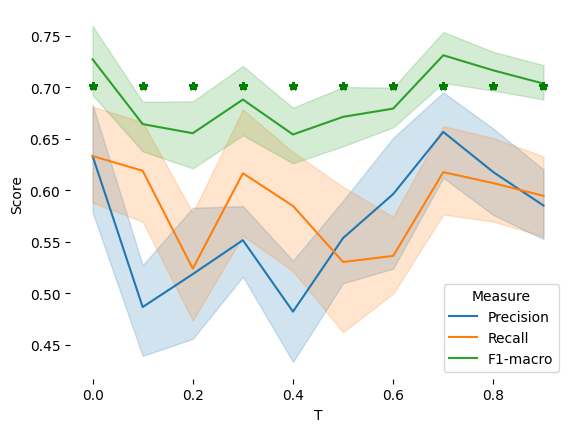

In [17]:
ax = xattds.hypothesis_testing(ssize=50)
ax.get_figure().savefig("attitudes_unimodal-eval.pdf", format="PDF", dpi=300)

The baseline (stars) struggles, especially because polarized (multimodal) items confuse it.
The hypothesis model with an explicit polarized class is more robust, achieving better or at least equal macro-F1 across thresholds.
It also shows the trade-off: high recall at low thresholds vs higher precision at stricter thresholds.

In [18]:
p, b, m = xattds.pvalue(th=0.6, ssize=50)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=np.float64(218.0), pvalue=np.float64(0.6920270882987056))
0.69 compared to the baseline: 0.69


In [19]:
p, b, m = xattds.pvalue(th=0.5, ssize=50)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=np.float64(223.0), pvalue=np.float64(0.7377693850797392))
0.67 compared to the baseline: 0.68


In [20]:
p, b, m = xattds.pvalue(th=0.4, ssize=50)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=np.float64(192.5), pvalue=np.float64(0.42467825824424216))
0.68 compared to the baseline: 0.68


AUC: 0.614
              precision    recall  f1-score   support

       civil       0.49      0.46      0.47        68
         k+1       0.53      0.56      0.55        71
       toxic       0.26      0.28      0.27        18

    accuracy                           0.48       157
   macro avg       0.43      0.43      0.43       157
weighted avg       0.48      0.48      0.48       157



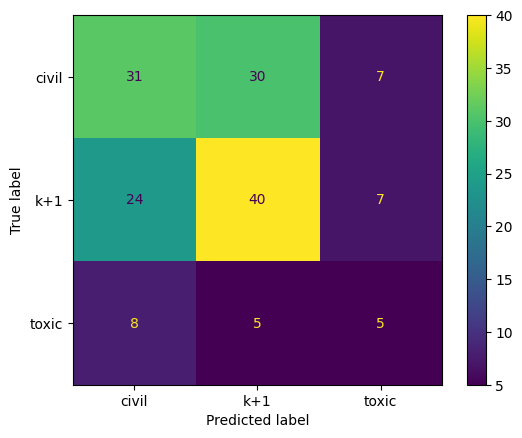

In [21]:
# 3-class assessment
th = 0.0
target = xattds.test.apply(lambda x: xattds.labeller(x.DFU, x.scores, th), 1)
prediction = xattds.models[th].predict(xattds.to_np(xattds.test.bert))
predict_probs = xattds.models[th].predict_proba(xattds.to_np(xattds.test.bert))
print(f"AUC: {roc_auc_score(target, predict_probs, average='macro', multi_class='ovr'):.3f}")
print(classification_report(target, prediction))
cm = ConfusionMatrixDisplay.from_predictions(target, prediction);
cm.figure_.savefig("attitudes-k+1.pdf", format="PDF", dpi=300)

K+1 approach shows good results, better than the baseline

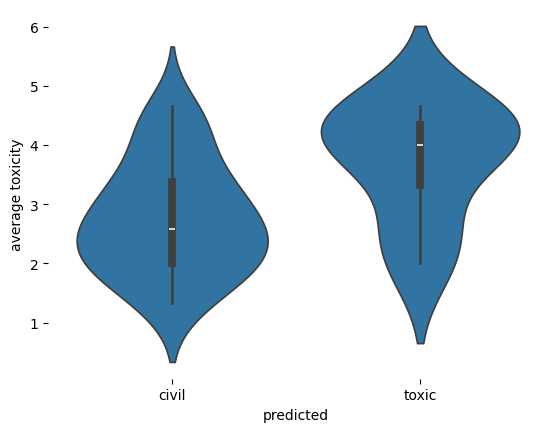

In [22]:
err1 = xattds.test[(target=="k+1")&(prediction=="civil")] # +1 said civil
err2 = xattds.test[(target=="k+1")&(prediction=="toxic")] # +1 said toxic
ax = sns.violinplot(data=pd.DataFrame({"average toxicity":(err1.scores.apply(np.mean)).to_list()+(6-err2.scores.apply(np.mean)).to_list(),
                                       "predicted": ["civil"]*err1.shape[0] + ["toxic"]*err2.shape[0]
                                       }), y="average toxicity", x="predicted");
sns.despine(left=True, bottom=True)

ax.get_figure().savefig("attitudes_violins.pdf", format="PDF", dpi=300)

# Investigating the support

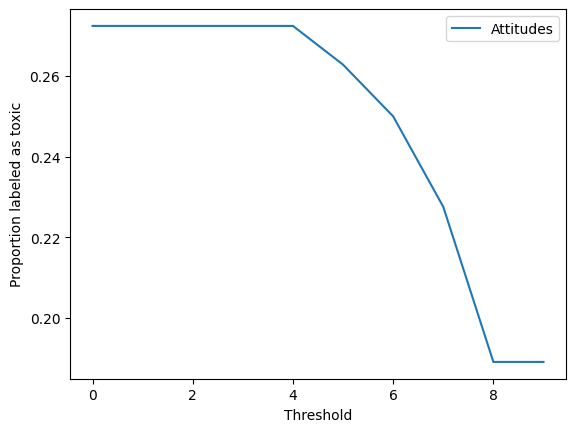

In [23]:
support_pd = pd.DataFrame()
for corpus, name in [(xattds, "Attitudes")]:
    s = []
    for th in corpus.thresholds:
        target = corpus.train.apply(lambda x: corpus.labeller(x.DFU, x.scores, th), axis=1)
        s.append((target == "toxic").sum() / corpus.train.shape[0])
    support_pd[name] = s

ax = support_pd.plot()
ax.set_xlabel("Threshold")
ax.set_ylabel("Proportion labeled as toxic")

plt.show()

Depending on how strict the threshold is, between 19% and 27% of Attitudes posts are considered toxic

# Exploratory

In [24]:
# === Dataset statistics for Attitudes only ===
name = "Attitudes"
dataset = att_train
text_col = "tweet"

print(f"{name}")
print(f"# chars (mean ± std): {dataset[text_col].apply(len).mean():.2f} ({dataset[text_col].apply(len).std():.2f})")
print(f"# instances: {dataset.shape[0]}")
print(f"# codes per instance (mean ± std): {dataset.scores.apply(len).mean():.2f} ({dataset.scores.apply(len).std():.2f})")


Attitudes
# chars (mean ± std): 133.65 (91.78)
# instances: 312
# codes per instance (mean ± std): 5.59 (0.76)


In [25]:
att_train.head()

,tweet,toyou,toany,annotatorminority,bert,annotatorpolitics,traditionalism,annotatorrace,annotatorage,annotatorgender,...,harmhatespeech,intent,lingpurism,racism,racist,scores,HIST,DFU,toxicity,target
208,I just want my fucking hair done :woman_facepa...,"[5, 3, 1, 3, 2, 2]","[4, 5, 1, 3, 4, 2]","[{}, NONE, {}, {}, Jewish, {}]","[0.25458770990371704, 0.05512981489300728, 0.1...","[-0.5, 1.0, 0.5, 0.5, -0.5, -0.5]","[5, 3, 3, 2, 4, 4]","[black, black, white, white, white, white]","[30.0, 45.0, 45.0, 35.0, 30.0, 25.0]","[woman, man, man, man, man, man]",...,"[3, 4, 3, 2, 4, 3]","[3, 3, 1, 2, 2, 2]","[5, 3, 4, 2, 3, 5]","[2, 2, 3, 3, 2, 2]","[1, 5, 1, 3, 1, 2]","[5, 3, 1, 3, 2, 2]","[0.16666666666666666, 0.3333333333333333, 0.33...",0.5,0.0,k+1
499,You seasonal ... part time .. you'll get fucke...,"[5, 5, 3, 2, 5, 4]","[5, 5, 3, 2, 5, 4]","[{}, {}, {}, none, {}, {}]","[0.23867294192314148, 0.29648762941360474, 0.2...","[-0.5, -1.0, 0.0, -0.5, -0.5, -0.5]","[4, 5, 5, 2, 5, 4]","[black, black, white, white, white, white]","[40.0, 25.0, 40.0, 50.0, 35.0, 40.0]","[woman, woman, woman, man, woman, man]",...,"[4, 5, 5, 2, 5, 4]","[5, 5, 3, 2, 5, 5]","[2, 5, 5, 5, 4, 4]","[1, 4, 1, 3, 1, 1]","[1, 3, 3, 1, 2, 1]","[5, 5, 3, 2, 5, 4]","[0.0, 0.16666666666666666, 0.16666666666666666...",0.0,0.0,civil
550,it always be those salty ass J.Cole fans tryin...,"[3, 2, 4, 1, 5, 3]","[4, 1, 4, 1, 5, 5]","[nan, {}, {}, {}, {}, Jewish]","[-0.19669391214847565, 0.1406891942024231, 0.0...","[0.0, -0.5, 0.0, 0.5, -1.0, -0.5]","[5, 3, 5, 4, 4, 4]","[black, black, other, white, white, white]","[55.0, 30.0, 55.0, 35.0, 30.0, 30.0]","[man, woman, man, woman, man, man]",...,"[5, 4, 5, 5, 5, 4]","[4, 2, 4, 1, 5, 5]","[5, 5, 5, 5, 4, 3]","[1, 1, 2, 1, 1, 2]","[2, 1, 1, 1, 1, 1]","[3, 2, 4, 1, 5, 3]","[0.16666666666666666, 0.16666666666666666, 0.3...",0.0,0.0,civil
406,"They all say these people are so low key, that...","[3, 4, 2, 3, 3]","[3, 3, 4, 3, 3]","[Black american, {}, None, {}, {}]","[0.37510836124420166, -0.007848048582673073, 0...","[-0.5, 0.5, 0.5, -0.5, -0.5]","[5, 3, 4, 5, 4]","[black, white, white, white, white]","[30.0, 35.0, 40.0, 45.0, 35.0]","[man, man, man, woman, woman]",...,"[5, 4, 3, 5, 4]","[3, 5, 1, 2, 3]","[5, 5, 4, 5, 4]","[5, 3, 2, 2, 1]","[3, 5, 2, 2, 3]","[3, 4, 2, 3, 3]","[0.0, 0.2, 0.6, 0.2, 0.0]",0.0,0.0,civil
440,"Wasniak was doing Donnie, his wife, and Julia ...","[5, 1, 2, 4, 4, 2]","[3, 2, 3, 4, 4, 2]","[nan, {}, {}, disability, {}, {}]","[-0.2718934416770935, 0.3137650191783905, 0.06...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[3, 5, 2, 5, 5, 1]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 65.0, 30.0, 30.0]","[man, man, man, woman, man, man]",...,"[3, 3, 2, 2, 5, 5]","[5, 1, 1, 4, 4, 2]","[5, 3, 5, 5, 5, 3]","[1, 1, 4, 3, 1, 1]","[1, 1, 1, 1, 1, 1]","[5, 1, 2, 4, 4, 2]","[0.16666666666666666, 0.3333333333333333, 0.0,...",1.0,0.0,k+1


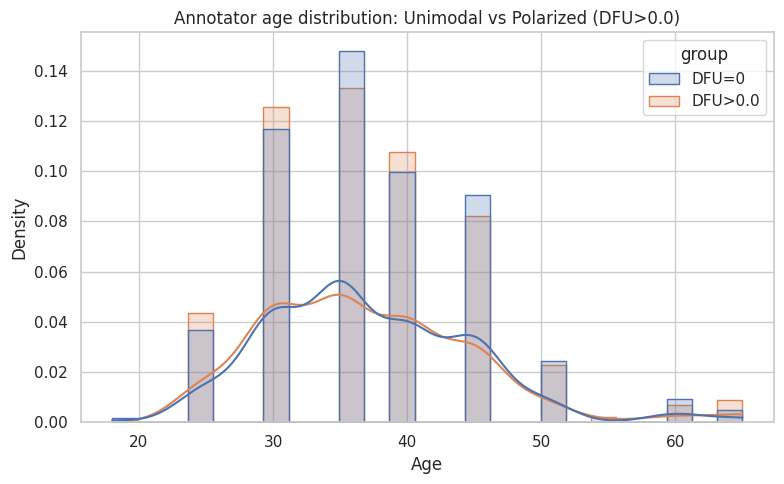

In [26]:
# Exploration by age
uni = att_train[att_train["DFU"] == 0]
pol = att_train[att_train["DFU"] > 0.0]

if len(uni):
    uni = uni.sample(n=min(100, len(uni)), random_state=42)
if len(pol):
    pol = pol.sample(n=min(100, len(pol)), random_state=42)


plot_df = pd.concat(
    [
        pd.DataFrame({"age": uni["annotatorage"].explode(), "group": "DFU=0"}),
        pd.DataFrame({"age": pol["annotatorage"].explode(), "group": "DFU>0.0"}),
    ],
    ignore_index=True,
).dropna(subset=["age"])

age_num = pd.to_numeric(plot_df["age"], errors="coerce")
is_numeric = age_num.notna().mean() > 0.8

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

if is_numeric:
    plot_df_num = plot_df.copy()
    plot_df_num["age"] = age_num
    plot_df_num = plot_df_num.dropna(subset=["age"])
    sns.histplot(
        data=plot_df_num,
        x="age",
        hue="group",
        kde=True,
        stat="density",
        common_norm=False,
        element="step",
        ax=ax,
    )
    ax.set_xlabel("Age")
    ax.set_ylabel("Density")
else:
    order = (
        plot_df["age"]
        .value_counts()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    sns.countplot(
        data=plot_df,
        x="age",
        hue="group",
        order=order,
        ax=ax,
    )
    ax.set_xlabel("Age (categories)")
    ax.set_ylabel("Count")

ax.set_title("Annotator age distribution: Unimodal vs Polarized (DFU>0.0)")

handles, labels = ax.get_legend_handles_labels()
if labels:
    ax.legend(handles=handles, labels=labels, title="Group")

plt.tight_layout()
plt.show()


In [27]:
from scipy.stats import ttest_ind

df = att_train[["annotatorage", "DFU"]].explode("annotatorage").dropna()
df["annotatorage"] = pd.to_numeric(df["annotatorage"], errors="coerce")
df = df.dropna(subset=["annotatorage"])

ages_uni = df.loc[df["DFU"] == 0, "annotatorage"]
ages_pol = df.loc[df["DFU"] > 0, "annotatorage"]

stat, p = ttest_ind(ages_uni, ages_pol, alternative="two-sided")
print(f"T-test: t={stat:.3f}, p={p:.4f}")

T-test: t=0.291, p=0.7714


At younger ages (20–30): polarized cases (orange) have a bit higher density. Suggests that younger annotators are slightly more involved in disagreement.

At mid-30s: unimodal cases (blue) dominate — agreement seems stronger among annotators in this age range.

At 40–45+: distributions overlap again, but unimodal cases show a bit more weight.

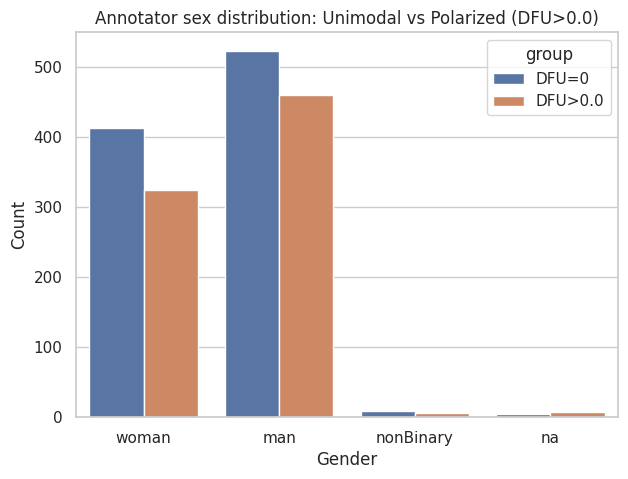

In [28]:
# Exploration by gender
uni = att_train[att_train["DFU"] == 0]
pol = att_train[att_train["DFU"] > 0.0]

s_uni = uni["annotatorgender"].explode().dropna()
s_pol = pol["annotatorgender"].explode().dropna()

plot_df = pd.concat(
    [
        pd.DataFrame({"sex": s_uni, "group": "DFU=0"}),
        pd.DataFrame({"sex": s_pol, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df, x="sex", hue="group")
plt.title("Annotator sex distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


In [29]:
from scipy.stats import chi2_contingency

df = att_train[["annotatorgender", "DFU"]].explode("annotatorgender")

contingency = pd.crosstab(df["annotatorgender"], df["DFU"] > 0)

print("Contingency table (rows=Gender, cols=DFU>0):")
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)

print("\nChi-square test results:")
print(f"χ² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")

print("\nExpected counts under independence:")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Contingency table (rows=Gender, cols=DFU>0):
DFU              False  True 
annotatorgender              
man                523    459
na                   4      8
nonBinary            9      6
woman              412    324

Chi-square test results:
χ² = 3.587, df = 3, p-value = 0.3097

Expected counts under independence:
DFU                   False       True 
annotatorgender                        
man              533.487679  448.512321
na                 6.519198    5.480802
nonBinary          8.148997    6.851003
woman            399.844126  336.155874


Since the p-value is 0.301 we cannot reject the null hypothesis

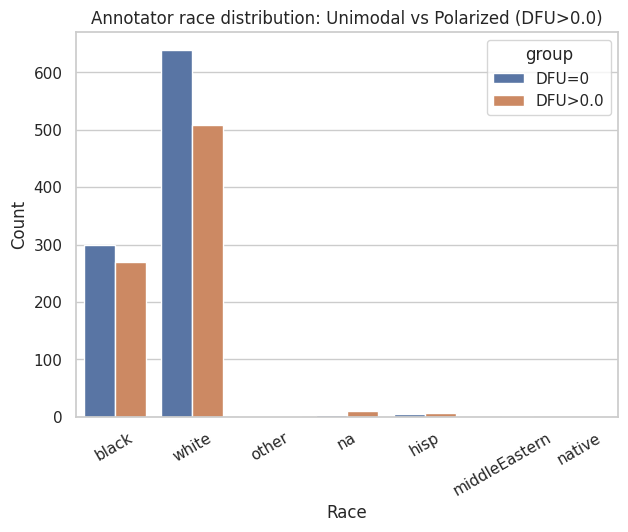

In [30]:
# Race exploration
s_uni = uni["annotatorrace"].explode().dropna()
s_pol = pol["annotatorrace"].explode().dropna()

plot_df = pd.concat(
    [
        pd.DataFrame({"race": s_uni, "group": "DFU=0"}),
        pd.DataFrame({"race": s_pol, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df, x="race", hue="group")
plt.title("Annotator race distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Race")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


This graph shows that white annotators dominate both unimodal (DFU=0) and polarized (DFU>0) cases, but their relative drop is larger in polarized ones, indicating they contribute more to disagreements.
Black annotators remain more balanced across the two groups, while other racial categories have very small counts, making their patterns unreliable.

In [31]:
df = att_train[["annotatorrace", "DFU"]].explode("annotatorrace")

contingency = pd.crosstab(df["annotatorrace"], df["DFU"] > 0)

print("Contingency table (rows=Race, cols=DFU>0):")
print(contingency)

chi2, p, dof, expected = chi2_contingency(contingency)

print("\nChi-square test results:")
print(f"χ² = {chi2:.3f}, df = {dof}, p-value = {p:.4f}")

print("\nExpected counts under independence:")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Contingency table (rows=Race, cols=DFU>0):
DFU            False  True 
annotatorrace              
black            299    269
hisp               5      6
middleEastern      0      1
na                 4     10
native             0      1
other              2      2
white            638    508

Chi-square test results:
χ² = 7.987, df = 6, p-value = 0.2390

Expected counts under independence:
DFU                 False       True 
annotatorrace                        
black          308.575358  259.424642
hisp             5.975931    5.024069
middleEastern    0.543266    0.456734
na               7.605731    6.394269
native           0.543266    0.456734
other            2.173066    1.826934
white          622.583381  523.416619


Since the p-value is 0.24 we cannot reject the null hypothesis

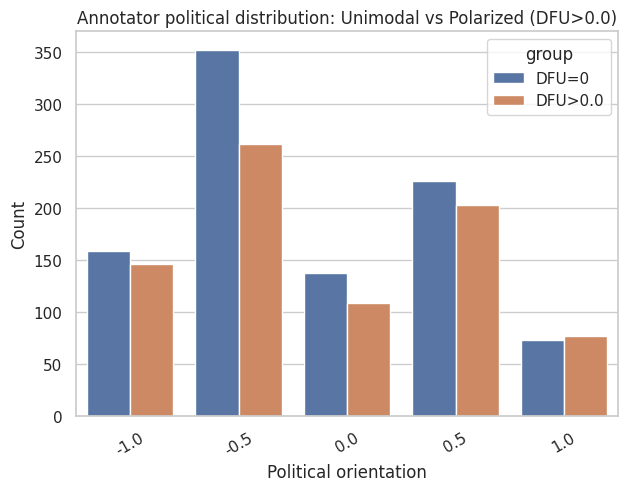

In [39]:
# Politics exploration
s_uni_pol = uni["annotatorpolitics"].explode().dropna()
s_pol_pol = pol["annotatorpolitics"].explode().dropna()

plot_df_pol = pd.concat(
    [
        pd.DataFrame({"politics": s_uni_pol, "group": "DFU=0"}),
        pd.DataFrame({"politics": s_pol_pol, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df_pol, x="politics", hue="group")
plt.title("Annotator political distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Political orientation")
plt.ylabel("Count")
plt.xticks(rotation=30)
plt.show()


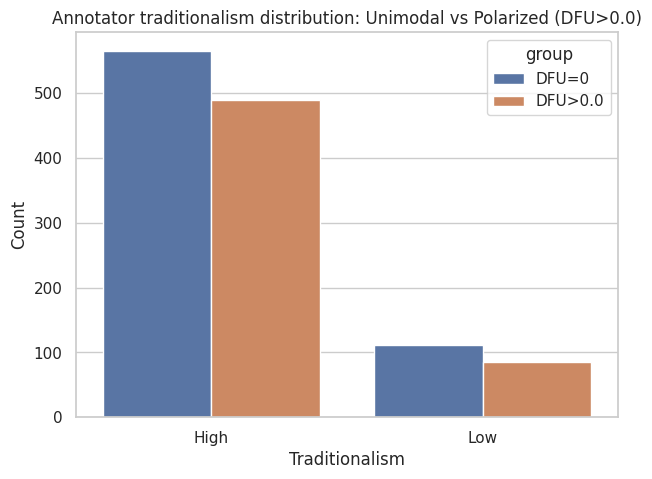

In [40]:
s_uni_trad = uni["traditionalism"].explode().dropna()
s_pol_trad = pol["traditionalism"].explode().dropna()

def recode_trad(x):
    if x in [1, 2]:
        return "Low"
    elif x in [4, 5]:
        return "High"
    else:
        return None

s_uni_trad = s_uni_trad.map(recode_trad).dropna()
s_pol_trad = s_pol_trad.map(recode_trad).dropna()

plot_df_trad = pd.concat(
    [
        pd.DataFrame({"traditionalism": s_uni_trad, "group": "DFU=0"}),
        pd.DataFrame({"traditionalism": s_pol_trad, "group": "DFU>0.0"}),
    ],
    ignore_index=True,
)

sns.set(style="whitegrid")
plt.figure(figsize=(7,5))
sns.countplot(data=plot_df_trad, x="traditionalism", hue="group")
plt.title("Annotator traditionalism distribution: Unimodal vs Polarized (DFU>0.0)")
plt.xlabel("Traditionalism")
plt.ylabel("Count")
plt.show()


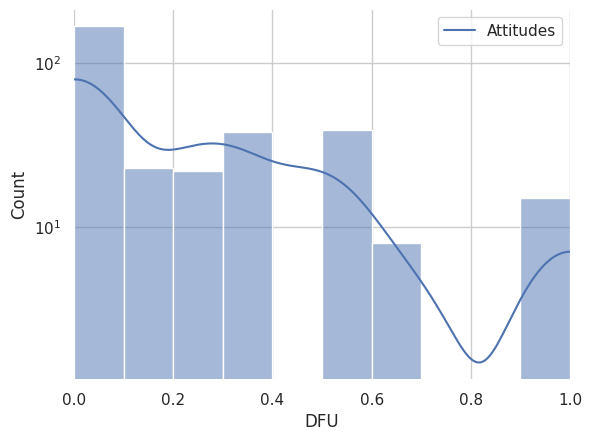

In [32]:
fig, ax = plt.subplots()
labels = []
for name, a in [("Attitudes", att_train)]:
    sns.histplot(a.DFU, ax=ax, kde=True, bins=10, legend=True)
    ax.set_yscale('log')
    ax.set_xlabel("DFU")
    labels.append(name)
plt.legend(labels=labels)
ax.set_xlim([0, 1])
sns.despine(bottom=True, left=True)
ax.get_figure().savefig("dfu_hists.pdf", format="PDF", dpi=300)

Most tweets in the Attitudes dataset have low DFU values (high annotator agreement), with fewer cases showing strong polarization at DFU ≈ 1 and very few in-between.

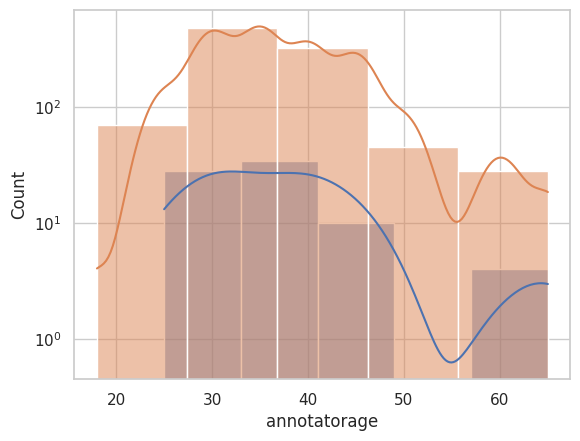

In [33]:
#Compare ages
fig, ax = plt.subplots()
sns.histplot(att_train[att_train.DFU>att_train.DFU.quantile(0.95)].annotatorage.explode(), ax=ax, kde=True, bins=5)
sns.histplot(att_train[att_train.DFU==0].annotatorage.explode(), ax=ax, kde=True, bins=5)
ax.set_xlabel("annotatorage")
ax.set_yscale('log')

**Unimodal agreement** is concentrated among mid-aged annotators (30s-40s), while the most polarized cases involve a broader mix of younger and older annotators (20 to 50+), suggesting that age diversity contributes to disagreement.

In [34]:
# xm_train[['comment', 'toxicity', 'toxicity_score', 'gender', 'age_group', 'education', 'HIST', 'DFU', 'target', 'scores']].to_csv("xm_train.csv", index=False)
# cctk_train[['text', 'scores', 'country', 'HIST', 'DFU']].to_csv("cctk_train.csv", index=False)
att_train[['tweet', 'toyou', 'toany', 'annotatorminority', 'annotatorpolitics', 'traditionalism', 'annotatorrace', 'annotatorage', 'annotatorgender', 'freespeech', 'harmhatespeech', 'intent', 'lingpurism', 'racism', 'racist', 'scores', 'HIST', 'DFU', 'toxicity', 'target']].to_csv("att_train.csv", index=False)

# A posteriori unimodal: Attitudes

In [41]:
# RECALL TO UPLOAD THE DATA
attitudes = pd.read_pickle("attitudes_embedded.csv")
scale = list(range(1,6))
attitudes["scores"] = attitudes.toyou
attitudes["HIST"] = attitudes.scores.apply(lambda x: pdf(x, scale))
attitudes["DFU"] = attitudes.HIST.apply(dfu)


## Focus on gender

We keep here the polarized texts where both men and women are present, have enough votes

In [42]:
high_pol = attitudes.DFU>0 # polarized
big_size = attitudes.annotatorGender.apply(len)>=6 # enough votes
supported = attitudes.annotatorGender.apply(lambda x: (Counter(x)["woman"]>1) and (Counter(x)["man"]>1)) # both groups present
shortlist = attitudes[high_pol&big_size&supported]
shortlist.shape

(135, 19)

In [43]:
dfu_gender = lambda row, gender="man", toxcol="toyou": dfu(pdf([row[toxcol][i] for i,g in enumerate(row.annotatorGender) if g==gender], scale))
x_gender = shortlist[(shortlist.apply(lambda r: dfu_gender(r, "man"), 1)==0)&(shortlist.apply(lambda r: dfu_gender(r, "woman"), 1)==0)]
x_gender

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
93,Bitches be too mad bitch get some money and mo...,"[5, 5, 2, 4, 4, 1]","[5, 5, 3, 4, 4, 2]","[{}, {}, none, {}, {}, {}]","[0.2549588084220886, -0.04279607906937599, 0.2...","[-0.5, -1.0, -0.5, 0.5, -0.5, -1.0]","[4, 5, 2, 3, 5, 4]","[black, black, white, white, white, white]","[40.0, 25.0, 50.0, 35.0, 35.0, 25.0]","[woman, woman, man, woman, woman, man]","[1, 3, 1, 1, 1, 1]","[4, 5, 2, 5, 5, 4]","[5, 5, 3, 4, 4, 1]","[2, 5, 5, 5, 4, 5]","[1, 4, 3, 3, 1, 1]","[2, 3, 2, 3, 3, 1]","[5, 5, 2, 4, 4, 1]","[0.16666666666666666, 0.16666666666666666, 0.0...",0.500000
289,Keep in mind that sexual contact of any kind w...,"[2, 5, 5, 3, 5, 1]","[4, 5, 5, 5, 5, 2]","[NONE, immigrant, black,, {}, {}, bisexual, Ve...","[-0.23865552246570587, -0.010829821228981018, ...","[1.0, 0.0, 0.5, 0.5, -0.5, -1.0]","[3, 3, 5, 3, 3, 5]","[black, black, white, white, white, white]","[45.0, 35.0, 35.0, 45.0, 40.0, 35.0]","[man, woman, woman, man, woman, man]","[5, 1, 1, 4, 1, 1]","[4, 4, 4, 3, 5, 5]","[3, 5, 5, 3, 5, 1]","[3, 4, 5, 4, 5, 5]","[5, 1, 2, 3, 1, 5]","[4, 1, 3, 1, 1, 1]","[2, 5, 5, 3, 5, 1]","[0.16666666666666666, 0.16666666666666666, 0.1...",0.333333
318,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,"[4, 4, 3, 2, 2, 2]","[4, 4, 2, 3, 2, 3]","[nan, {}, {}, {}, {}, {}]","[-0.21125884354114532, 0.3873864412307739, -0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -0.5]","[3, 5, 2, 4, 4, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 35.0, 35.0, 45.0]","[man, man, man, woman, woman, woman]","[1, 1, 5, 1, 2, 1]","[3, 3, 2, 3, 3, 4]","[5, 4, 3, 2, 3, 2]","[5, 3, 5, 5, 4, 4]","[1, 1, 4, 1, 2, 1]","[1, 1, 1, 1, 1, 1]","[4, 4, 3, 2, 2, 2]","[0.0, 0.5, 0.16666666666666666, 0.333333333333...",0.333333
369,Sometimes I'll cut a jawn off just for being s...,"[4, 1, 4, 3, 2, 2]","[3, 1, 5, 4, 2, 3]","[nan, {}, {}, {}, {}, {}]","[0.22918452322483063, 0.273483544588089, -0.15...","[-0.5, -0.5, 0.5, 0.0, -0.5, -1.0]","[3, 5, 5, 5, 4, 1]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 30.0, 35.0, 30.0]","[man, woman, man, man, woman, man]","[1, 1, 1, 2, 2, 1]","[3, 3, 5, 4, 3, 5]","[5, 1, 5, 3, 4, 5]","[5, 5, 5, 4, 4, 3]","[1, 2, 1, 3, 2, 1]","[1, 1, 1, 3, 1, 1]","[4, 1, 4, 3, 2, 2]","[0.16666666666666666, 0.3333333333333333, 0.16...",0.500000
516,boy i've never been in a fight before but i fr...,"[4, 3, 3, 1, 3, 1]","[3, 3, 3, 2, 3, 3]","[nan, none, {}, {}, {}, bisexual]","[-0.011250785551965237, 0.03692465275526047, 0...","[-0.5, 0.0, 0.5, 0.5, -0.5, -0.5]","[3, 3, 5, 4, 3, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 30.0, 40.0]","[man, man, man, woman, man, woman]","[1, 3, 1, 1, 1, 1]","[3, 2, 5, 3, 5, 5]","[2, 3, 5, 1, 2, 4]","[5, 5, 5, 5, 1, 5]","[1, 3, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[4, 3, 3, 1, 3, 1]","[0.3333333333333333, 0.0, 0.5, 0.1666666666666...",0.666667
556,let me tell you hey fuck you who ever made thi...,"[3, 2, 5, 5, 5, 5]","[4, 2, 4, 5, 5, 5]","[{}, {}, {}, None, immigrant, {}]","[-0.19164827466011047, 0.24510705471038818, 0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -1.0]","[3, 3, 3, 4, 5, 4]","[black, black, white, white, white, white]","[35.0, 30.0, 35.0, 40.0, 40.0, 30.0]","[woman, woman, man, man, man, man]","[1, 1, 1, 2, 5, 3]","[4, 4, 4, 3, 5, 5]","[3, 2, 5, 4, 5, 5]","[3, 5, 5, 4, 5, 4]","[1, 1, 3, 2, 2, 1]","[3, 1, 5, 4, 5, 5]","[3, 2, 5, 5, 5, 5]","[0.0, 0.16666666666666666, 0.16666666666666666...",0.250000


In [44]:
x_gender.shape

(6, 19)

In only 6 tweets women agree with themselvs and men with themselves

In [45]:
x_gender.to_excel('aposteriori_unimodal_attitudes.gender.xlsx')

## Focus on Race

In [46]:
race_idx = {
    "black": 1,
    "white": 0,
    "hisp": -1,
    "na": -1,
    "other": -1,
    "native": -1,
    "middleEastern": -1
}

big_size = attitudes.annotatorRace.apply(len) == 6  # exactly 6 annotators
supported = attitudes.annotatorRace.apply(
    lambda x: (Counter(x)["black"] > 1) and (Counter(x)["white"] > 1)
)

shortlist = attitudes[high_pol & big_size & supported]
shortlist.shape


(181, 19)

In [47]:
#Extract text where men agree themselves and the same applies for women
dfu_condition = lambda row, key="black", toxcol="toyou", key_col='annotatorRace': dfu(pdf([row[toxcol][i] for i,g in enumerate(row[key_col]) if g==key], scale))
x_race = shortlist[(shortlist.apply(lambda r: dfu_condition(r, key="black", key_col='annotatorRace'), 1)==0)&(shortlist.apply(lambda r: dfu_condition(r, "white", key_col='annotatorRace'), 1)==0)]
x_race

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
309,My mom so aggravating every time I like a car ...,"[4, 4, 2, 2, 1, 2]","[4, 5, 2, 2, 2, 2]","[{}, {}, {}, {}, {}, {}]","[0.09306392818689346, -0.14795063436031342, 0....","[-0.5, -1.0, 0.0, 0.5, -0.5, -0.5]","[4, 5, 5, 3, 5, 5]","[black, black, white, white, white, white]","[40.0, 25.0, 40.0, 35.0, 35.0, 35.0]","[woman, woman, woman, woman, woman, woman]","[1, 3, 1, 1, 1, 1]","[4, 5, 5, 5, 5, 5]","[4, 4, 2, 2, 2, 3]","[2, 5, 5, 5, 4, 4]","[1, 4, 1, 3, 1, 1]","[1, 3, 1, 1, 1, 1]","[4, 4, 2, 2, 1, 2]","[0.16666666666666666, 0.5, 0.0, 0.333333333333...",0.666667
318,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,"[4, 4, 3, 2, 2, 2]","[4, 4, 2, 3, 2, 3]","[nan, {}, {}, {}, {}, {}]","[-0.21125884354114532, 0.3873864412307739, -0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -0.5]","[3, 5, 2, 4, 4, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 35.0, 35.0, 45.0]","[man, man, man, woman, woman, woman]","[1, 1, 5, 1, 2, 1]","[3, 3, 2, 3, 3, 4]","[5, 4, 3, 2, 3, 2]","[5, 3, 5, 5, 4, 4]","[1, 1, 4, 1, 2, 1]","[1, 1, 1, 1, 1, 1]","[4, 4, 3, 2, 2, 2]","[0.0, 0.5, 0.16666666666666666, 0.333333333333...",0.333333
342,Reminds me about a guy on 4chan who genuinely ...,"[4, 3, 4, 1, 1, 1]","[4, 3, 4, 1, 2, 2]","[{}, {}, {}, {}, Veteran, {}]","[-0.04991382732987404, -0.11697617918252945, -...","[-1.0, 0.0, 0.5, 0.0, -1.0, -0.5]","[5, 4, 5, 5, 5, 5]","[black, black, hisp, white, white, white]","[25.0, 35.0, 30.0, 40.0, 35.0, 35.0]","[woman, man, man, woman, man, woman]","[3, 1, 3, 1, 1, 1]","[5, 4, 5, 5, 5, 5]","[3, 2, 2, 1, 1, 1]","[5, 4, 4, 5, 5, 4]","[4, 1, 1, 1, 5, 1]","[5, 3, 4, 1, 1, 1]","[4, 3, 4, 1, 1, 1]","[0.5, 0.0, 0.16666666666666666, 0.333333333333...",0.333333
357,Sick to death of either seein nobs or ur minge...,"[5, 5, 3, 2, 2, 3]","[5, 5, 3, 3, 2, 3]","[{}, {}, none, {}, {}, {}]","[-0.042324356734752655, 0.20226505398750305, -...","[-0.5, 0.0, -0.5, 0.0, -0.5, -1.0]","[4, 5, 2, 2, 2, 4]","[black, black, white, white, white, white]","[40.0, 45.0, 50.0, 35.0, 40.0, 25.0]","[woman, man, man, man, man, man]","[1, 1, 1, 3, 1, 1]","[4, 5, 2, 2, 4, 4]","[4, 5, 2, 2, 3, 3]","[2, 4, 5, 3, 5, 5]","[1, 1, 3, 1, 1, 1]","[1, 5, 1, 1, 1, 1]","[5, 5, 3, 2, 2, 3]","[0.0, 0.3333333333333333, 0.3333333333333333, ...",1.000000
364,So can we just stop saying there is no racism ...,"[5, 4, 2, 5, 5, 4]","[5, 4, 4, 5, 5, 5]","[Black american, {}, {}, {}, {}, {}]","[-0.12828494608402252, 0.061020202934741974, 0...","[-0.5, -0.5, 0.0, 0.5, -1.0, -1.0]","[5, 3, 5, 4, 4, 5]","[black, black, other, white, white, white]","[30.0, 30.0, 55.0, 35.0, 30.0, 45.0]","[man, woman, man, woman, man, woman]","[1, 1, 2, 1, 3, 1]","[5, 4, 5, 5, 5, 5]","[5, 4, 2, 5, 5, 3]","[5, 5, 5, 5, 4, 5]","[5, 1, 2, 1, 1, 1]","[5, 2, 2, 5, 5, 3]","[5, 4, 2, 5, 5, 4]","[0.0, 0.16666666666666666, 0.0, 0.333333333333...",0.333333
423,This raghead colleague is such a traitor!,"[3, 3, 5, 5, 5, 5]","[3, 3, 3, 5, 2, 5]","[Black american, {}, {}, {}, {}, nan]","[0.04868575558066368, 0.5501320958137512, -0.1...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[5, 3, 3, 4, 2, 5]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 35.0, 45.0]","[man, woman, man, woman, woman, woman]","[1, 1, 1, 1, 1, 1]","[5, 4, 4, 5, 5, 5]","[3, 4, 4, 5, 5, 5]","[5, 5, 5, 5, 4, 3]","[5, 1, 3, 1, 1, 1]","[1, 4, 4, 4, 5, 5]","[3, 3, 5, 5, 5, 5]","[0.0, 0.0, 0.3333333333333333, 0.0, 0.66666666...",0.500000
546,"imagine being such absolute scum, I want those...","[5, 5, 4, 1, 5, 5]","[5, 5, 5, 2, 5, 5]","[{}, {}, nan, {}, {}, {}]","[0.3449878394603729, 0.44626960158348083, 0.12...","[-1.0, 0.0, 1.0, 0.5, -0.5, -0.5]","[5, 4, 3, 5, 5, 3]","[black, black, white, hisp, white, white]","[25.0, 35.0, 35.0, 30.0, 35.0, 45.0]","[woman, man, man, man, woman, woman]","[3, 1, 5, 3, 1, 2]","[5, 4, 1, 5, 5, 3]

In [48]:
x_race.shape

(9, 19)

In [49]:
 x_race.to_excel('aposteriori_unimodal_attitudes.race.xlsx')

In [50]:
def extract_examples_with_means(df, dim_col, toxcol="toyou", threshold=3, drop_na=False):
    examples = []
    all_groups = set()

    for _, row in df.iterrows():
        entry = {"tweet": row["tweet"]}
        for grp in set(row[dim_col]):
            scores = [row[toxcol][i] for i, g in enumerate(row[dim_col]) if g == grp]

            if not scores:
                label, mean = "NA", None
            else:
                labels = ["toxic" if s >= threshold else "civil" for s in scores]
                counts = Counter(labels)
                if len(counts) == 2 and counts["toxic"] == counts["civil"]:
                    label = "tie"
                else:
                    label = max(counts, key=counts.get)
                mean = np.mean(scores)

            entry[f"{grp}_label"] = label
            entry[f"{grp}_mean"] = mean
            all_groups.add(grp)
        examples.append(entry)

    result = pd.DataFrame(examples)
    if drop_na:
      result=result.dropna(axis=1, how='any')
    return result

In [51]:
df_race = extract_examples_with_means(x_race, "annotatorRace", "toyou", threshold=3,drop_na=True)
print(df_race)


                                               tweet white_label  white_mean  \
0  My mom so aggravating every time I like a car ...       civil    1.750000   
1  No clout. I WONT GIVE A RAT NO FAME I WON'T GI...       civil    2.250000   
2  Reminds me about a guy on 4chan who genuinely ...       civil    1.000000   
3  Sick to death of either seein nobs or ur minge...         tie    2.500000   
4  So can we just stop saying there is no racism ...       toxic    4.666667   
5          This raghead colleague is such a traitor!       toxic    5.000000   
6  imagine being such absolute scum, I want those...       toxic    4.666667   
7  let me tell you hey fuck you who ever made thi...       toxic    5.000000   
8  you've got to be fucking joking, my room has l...       civil    1.250000   

  black_label  black_mean  
0       toxic         4.0  
1       toxic         4.0  
2       toxic         3.5  
3       toxic         5.0  
4       toxic         4.5  
5       toxic         3.0  
6  

In [52]:
def filter_different_labels(df):
    drop_indices = []
    for idx, row in df.iterrows():
        if row["white_label"] == row["black_label"]:
            print(f"White mean: {row['white_mean']}, Black mean: {row['black_mean']}")
            drop_indices.append(idx)
    return df.drop(drop_indices)


In [53]:
df_race=filter_different_labels(df_race)


White mean: 4.666666666666667, Black mean: 4.5
White mean: 5.0, Black mean: 3.0
White mean: 4.666666666666667, Black mean: 5.0


# **Focus on Age**

AU (Association Uncertainty) is the metric you maximize to choose the age threshold that best explains polarization (DFU>0 vs DFU=0).


In [ ]:
# ---Polarized posts only ---
polarized_df = att_train[att_train["DFU"] > 0].copy()

# Explode to annotator level
polarized_exploded = polarized_df[["annotatorage", "scores"]].explode(["annotatorage", "scores"])
polarized_exploded = polarized_exploded.dropna(subset=["annotatorage", "scores"])

# Convert to numeric
polarized_exploded["age"] = pd.to_numeric(polarized_exploded["annotatorage"], errors="coerce")
polarized_exploded["tox"] = pd.to_numeric(polarized_exploded["scores"], errors="coerce")
polarized_exploded = polarized_exploded.dropna(subset=["age", "tox"])

# --- Binarize scores ---
polarized_exploded["label"] = (polarized_exploded["tox"] >= 3).astype(int)

ages = polarized_exploded["age"].astype(int).values
y = polarized_exploded["label"].values

# ---Treshold search using AUC ---
best_thr, best_auc = None, -1
thresholds = np.arange(ages.min(), ages.max()+1)

for thr in thresholds:
    preds = (ages > thr).astype(int)  # group assignment
    auc = roc_auc_score(y, preds)
    if auc > best_auc:
        best_auc, best_thr = auc, thr

print(f"✅ Best age threshold (AUC, polarized only): {best_thr}, AUC = {best_auc:.3f}")


✅ Best age threshold (AUC, polarized only): 35, AUC = 0.532


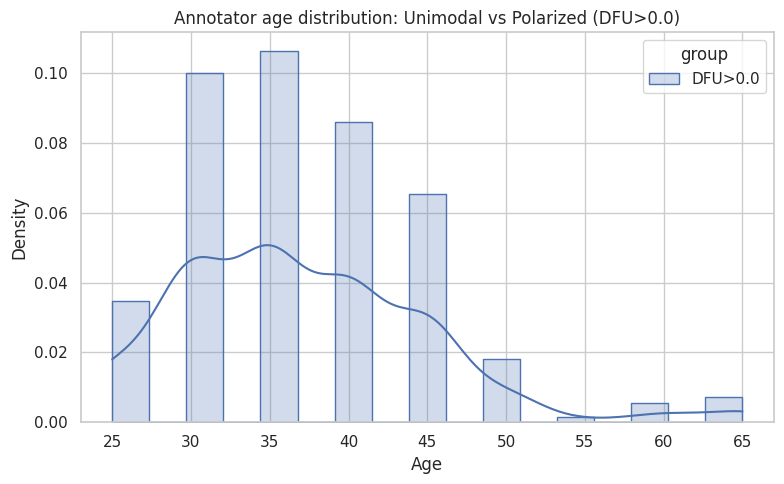

In [ ]:
# Exploration by age
pol = att_train[att_train["DFU"] > 0.0]

if len(pol):
    pol = pol.sample(n=min(100, len(pol)), random_state=42)


plot_df = pd.concat(
    [
        pd.DataFrame({"age": pol["annotatorage"].explode(), "group": "DFU>0.0"}),
    ],
    ignore_index=True,
).dropna(subset=["age"])

age_num = pd.to_numeric(plot_df["age"], errors="coerce")
is_numeric = age_num.notna().mean() > 0.8

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

if is_numeric:
    plot_df_num = plot_df.copy()
    plot_df_num["age"] = age_num
    plot_df_num = plot_df_num.dropna(subset=["age"])
    sns.histplot(
        data=plot_df_num,
        x="age",
        hue="group",
        kde=True,
        stat="density",
        common_norm=False,
        element="step",
        ax=ax,
    )
    ax.set_xlabel("Age")
    ax.set_ylabel("Density")
else:
    order = (
        plot_df["age"]
        .value_counts()
        .sort_values(ascending=False)
        .index
        .tolist()
    )
    sns.countplot(
        data=plot_df,
        x="age",
        hue="group",
        order=order,
        ax=ax,
    )
    ax.set_xlabel("Age (categories)")
    ax.set_ylabel("Count")

ax.set_title("Annotator age distribution: Unimodal vs Polarized (DFU>0.0)")

handles, labels = ax.get_legend_handles_labels()
if labels:
    ax.legend(handles=handles, labels=labels, title="Group")

plt.tight_layout()
plt.show()


# **Traditionalism**

In [54]:
def dfu_trad(row, group="low", toxcol="toyou"):
    vals = []
    for i, g in enumerate(row["traditionalism"]):
        if (g in [1, 2] and group == "low") \
           or (g in [4, 5] and group == "high"):
            vals.append(row[toxcol][i])
    if len(vals) == 0:   # no annotators in this group
        return 0
    return dfu(pdf(vals, scale))


In [55]:
x_trad = shortlist[
    (shortlist.apply(lambda r: dfu_trad(r, "low"), 1) == 0) &
    (shortlist.apply(lambda r: dfu_trad(r, "high"), 1) == 0)
]

x_trad.head()


,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
5,"""""""We gon' sit on an airplane~ gon' sit on air...","[1, 4, 1, 1, 1, 1]","[1, 2, 1, 1, 1, 1]","[{}, NONE, {}, {}, {}, {}]","[0.04155755043029785, -0.05615793168544769, 0....","[-1.0, 1.0, 0.5, 0.5, -0.5, -0.5]","[5, 3, 2, 3, 4, 2]","[black, black, white, white, white, white]","[45.0, 45.0, 40.0, 45.0, 40.0, 40.0]","[man, man, man, man, woman, man]","[1, 5, 5, 4, 1, 1]","[5, 4, 2, 3, 3, 4]","[1, 3, 1, 1, 1, 1]","[5, 3, 5, 4, 5, 5]","[1, 5, 4, 3, 2, 1]","[1, 5, 1, 1, 1, 1]","[1, 4, 1, 1, 1, 1]","[0.8333333333333334, 0.0, 0.0, 0.1666666666666...",0.200000
10,""":joy::joy::joy:. """"@Iam_Wynona: Mom is defeat...","[1, 4, 2, 2, 1, 1]","[1, 3, 2, 2, 1, 1]","[{}, NONE, {}, none, bisexual, {}]","[0.01737247034907341, -0.08470334112644196, 0....","[-1.0, 1.0, 0.0, 0.5, -0.5, -0.5]","[5, 3, 5, 5, 3, 4]","[black, black, white, white, white, white]","[45.0, 45.0, 30.0, 60.0, 40.0, 50.0]","[man, man, man, woman, woman, woman]","[1, 5, 2, 1, 1, 1]","[5, 4, 4, 5, 5, 4]","[1, 4, 2, 2, 1, 1]","[5, 3, 4, 5, 5, 4]","[1, 5, 3, 1, 1, 1]","[1, 3, 1, 1, 1, 1]","[1, 4, 2, 2, 1, 1]","[0.5, 0.3333333333333333, 0.0, 0.1666666666666...",0.333333
32,"""My Grammy never stops talking. She will talk ...","[2, 1, 3, 3, 1, 1]","[2, 1, 4, 3, 1, 1]","[Black american, {}, {}, {}, {}, {}]","[0.374459445476532, 0.1750366985797882, 0.1839...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[5, 3, 3, 4, 4, 4]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 40.0, 30.0]","[man, woman, man, woman, man, man]","[1, 1, 1, 1, 1, 3]","[5, 4, 4, 5, 5, 5]","[2, 1, 4, 2, 1, 1]","[5, 5, 5, 5, 3, 4]","[5, 1, 3, 1, 1, 1]","[1, 1, 4, 1, 1, 1]","[2, 1, 3, 3, 1, 1]","[0.5, 0.16666666666666666, 0.3333333333333333,...",0.333333
43,"""i really hate giving advice bc mfs be like """"...","[5, 2, 3, 4, 2, 5]","[5, 2, 4, 4, 2, 5]","[Black american, {}, {}, {}, {}, Jewish]","[0.2569565176963806, -0.3266155421733856, 0.32...","[-0.5, -0.5, 0.5, 1.0, -1.0, -0.5]","[5, 3, 4, 5, 4, 4]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 45.0, 30.0, 30.0]","[man, woman, woman, man, man, man]","[1, 1, 1, 2, 3, 1]","[5, 4, 5, 2, 5, 4]","[5, 3, 4, 3, 2, 5]","[5, 5, 5, 5, 4, 3]","[5, 1, 1, 5, 1, 2]","[5, 2, 4, 2, 2, 5]","[5, 2, 3, 4, 2, 5]","[0.0, 0.3333333333333333, 0.16666666666666666,...",0.500000
83,Anti-Slavery International should be destroyed...,"[5, 3, 5, 5, 5, 5]","[5, 5, 5, 5, 5, 5]","[{}, NONE, {}, {}, {}, {}]","[-0.37133079767227173, 0.29982033371925354, -0...","[-1.0, 1.0, 0.5, 0.5, -0.5, -0.5]","[5, 3, 5, 3, 4, 4]","[black, black, white, white, white, white]","[45.0, 45.0, 35.0, 45.0, 40.0, 50.0]","[man, man, woman, man, man, woman]","[1, 5, 1, 4, 2, 1]","[5, 4, 4, 3, 4, 4]","[5, 3, 3, 5, 5, 5]","[5, 3, 5, 4, 3, 4]","[1, 2, 2, 3, 2, 1]","[5, 5, 5, 5, 5, 5]","[5, 3, 5, 5, 5, 5]","[0.0, 0.0, 0.16666666666666666, 0.0, 0.8333333...",0.200000


In [56]:
x_trad.shape

(57, 19)

In [57]:
 x_trad.to_excel('aposteriori_unimodal_attitudes.traditionalism.xlsx')

**Politics**

In [58]:
shortlist = shortlist.copy()

def dfu_pol(row, group="left", toxcol="toyou"):
    vals = [
        row[toxcol][i] for i, g in enumerate(row.annotatorPolitics)
        if (g in [-1, -0.5] and group == "left")
        or (g == 0 and group == "center")
        or (g in [0.5, 1] and group == "right")
    ]
    if len(vals) == 0:
        return 0
    return dfu(pdf(vals, scale))

x_pol = shortlist[
    (shortlist.apply(lambda r: dfu_pol(r, "left"), 1) == 0) &
    (shortlist.apply(lambda r: dfu_pol(r, "center"), 1) == 0) &
    (shortlist.apply(lambda r: dfu_pol(r, "right"), 1) == 0)
]
x_pol.head()

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
32,"""My Grammy never stops talking. She will talk ...","[2, 1, 3, 3, 1, 1]","[2, 1, 4, 3, 1, 1]","[Black american, {}, {}, {}, {}, {}]","[0.374459445476532, 0.1750366985797882, 0.1839...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[5, 3, 3, 4, 4, 4]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 40.0, 30.0]","[man, woman, man, woman, man, man]","[1, 1, 1, 1, 1, 3]","[5, 4, 4, 5, 5, 5]","[2, 1, 4, 2, 1, 1]","[5, 5, 5, 5, 3, 4]","[5, 1, 3, 1, 1, 1]","[1, 1, 4, 1, 1, 1]","[2, 1, 3, 3, 1, 1]","[0.5, 0.16666666666666666, 0.3333333333333333,...",0.333333
53,"#feminists disagree, for a generation that gre...","[1, 1, 3, 3, 1, 1]","[1, 1, 4, 3, 3, 1]","[Black american, {}, {}, {}, Jewish, nan]","[0.32393571734428406, -0.15556733310222626, 0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -1.0]","[5, 3, 3, 4, 4, 5]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 30.0, 45.0]","[man, woman, man, woman, man, woman]","[1, 1, 1, 1, 1, 1]","[5, 4, 4, 5, 4, 5]","[1, 1, 4, 4, 1, 1]","[5, 5, 5, 5, 3, 3]","[5, 1, 3, 1, 2, 1]","[1, 1, 1, 3, 1, 1]","[1, 1, 3, 3, 1, 1]","[0.6666666666666666, 0.0, 0.3333333333333333, ...",0.500000
99,British native youth have completely given in ...,"[5, 5, 3, 5, 5, 5]","[5, 5, 5, 5, 5, 5]","[{}, black; female, nan, none, {}, {}]","[0.13886664807796478, 0.14132989943027496, -0....","[-1.0, -1.0, 1.0, -0.5, -1.0, -0.5]","[3, 3, 3, 2, 1, 3]","[black, black, white, white, white, white]","[25.0, 40.0, 35.0, 50.0, 25.0, 45.0]","[man, woman, man, man, man, woman]","[1, 1, 5, 1, 1, 1]","[4, 5, 1, 2, 5, 4]","[5, 5, 3, 5, 5, 4]","[3, 4, 5, 5, 5, 4]","[1, 1, 5, 3, 1, 1]","[5, 5, 5, 5, 5, 5]","[5, 5, 3, 5, 5, 5]","[0.0, 0.0, 0.16666666666666666, 0.0, 0.8333333...",0.200000
131,"Exactly, not only that but BLM has been talkin...","[5, 5, 1, 5, 5, 5]","[5, 5, 4, 5, 5, 5]","[{}, black; female, nan, {}, {}, {}]","[0.1108744814991951, 0.056330613791942596, 0.0...","[0.0, -1.0, 1.0, 0.0, -0.5, -1.0]","[4, 3, 3, 5, 3, 4]","[black, black, white, white, white, white]","[35.0, 40.0, 35.0, 40.0, 45.0, 25.0]","[man, woman, man, woman, woman, man]","[1, 1, 5, 1, 2, 1]","[4, 5, 1, 5, 3, 4]","[5, 5, 1, 5, 5, 5]","[4, 4, 5, 5, 3, 5]","[1, 1, 5, 1, 2, 1]","[5, 5, 2, 5, 5, 5]","[5, 5, 1, 5, 5, 5]","[0.16666666666666666, 0.0, 0.0, 0.0, 0.8333333...",0.200000
172,"I always hated visiting Nig York, but if I'm e...","[5, 5, 3, 5, 5, 5]","[5, 5, 5, 5, 5, 5]","[{}, {}, nan, none, {}, {}]","[0.18953466415405273, -0.12954939901828766, 0....","[-0.5, 0.0, 1.0, -0.5, -0.5, -0.5]","[4, 4, 3, 2, 5, 5]","[black, black, white, white, white, white]","[40.0, 35.0, 35.0, 50.0, 35.0, 35.0]","[woman, man, man, man, woman, woman]","[1, 1, 5, 1, 1, 1]","[4, 4, 1, 2, 5, 5]","[5, 5, 5, 5, 5, 5]","[2, 4, 5, 5, 4, 4]","[1, 1, 5, 3, 1, 1]","[5, 5, 5, 5, 5, 5]","[5, 5, 3, 5, 5, 5]","[0.0, 0.0, 0.16666666666666666, 0.0, 0.8333333...",0.200000


In [59]:
x_pol.shape

(20, 19)

In [60]:
 x_pol.to_excel('aposteriori_unimodal_attitudes.politics.xlsx')

# **Save all the results in one big table**

In [147]:
gender_df = pd.read_excel("aposteriori_unimodal_attitudes.gender.xlsx")
race_df = pd.read_excel("aposteriori_unimodal_attitudes.race.xlsx")
politics_df = pd.read_excel("aposteriori_unimodal_attitudes.politics.xlsx")
trad_df = pd.read_excel("aposteriori_unimodal_attitudes.traditionalism.xlsx")

In [148]:
import ast

def ensure_list_col(df, col):
    return df[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[")
        else ([x] if not isinstance(x, list) else x)
    )


In [149]:
def build_final_summary(base_df, means_df, dimension):
    out_rows = []

    for i, row in base_df.iterrows():
        tweet = row["tweet"]
        dfu = row["DFU"]

        means_row = means_df.loc[means_df["tweet"] == tweet]
        if means_row.empty:
            continue
        means_row = means_row.iloc[0]

        poles = {}
        for col in means_row.index:
            if col.endswith("_label") and means_row[col] not in [None, "NA"] and pd.notna(means_row[col]):
                grp = col.replace("_label", "")
                poles[grp] = means_row[col]

        try:
            sorted_keys = sorted(poles.keys(), key=lambda x: float(x))
        except:
            sorted_keys = sorted(poles.keys())

        toxic_pole = "{" + ", ".join(f"{k}:{poles[k]}" for k in sorted_keys) + "}"

        out_rows.append({
            "tweet": tweet,
            "DFU": dfu,
            "dimension": dimension,
            "toxic_pole": toxic_pole
        })

    return pd.DataFrame(out_rows, columns=["tweet", "DFU", "dimension", "toxic_pole"])


In [150]:
gender_df = gender_df.copy()
gender_df["annotatorGender"] = ensure_list_col(gender_df, "annotatorGender")
gender_df["toyou"] = ensure_list_col(gender_df, "toyou")

helper_gender = extract_examples_with_means(gender_df, "annotatorGender", "toyou", threshold=3)
gender=build_final_summary(gender_df,helper_gender,"gender")
gender.head()

,tweet,DFU,dimension,toxic_pole
0,Bitches be too mad bitch get some money and mo...,0.500000,gender,"{man:civil, woman:toxic}"
1,Keep in mind that sexual contact of any kind w...,0.333333,gender,"{man:civil, woman:toxic}"
2,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,gender,"{man:toxic, woman:civil}"
3,Sometimes I'll cut a jawn off just for being s...,0.500000,gender,"{man:toxic, woman:civil}"
4,boy i've never been in a fight before but i fr...,0.666667,gender,"{man:toxic, woman:civil}"


In [151]:
race_df = race_df.copy()
race_df["annotatorRace"] = ensure_list_col(race_df, "annotatorRace")
race_df["toyou"] = ensure_list_col(race_df, "toyou")

helper_race = extract_examples_with_means(race_df, "annotatorRace", "toyou", threshold=3)
race=build_final_summary(race_df,helper_race,"race")
race.head()


,tweet,DFU,dimension,toxic_pole
0,My mom so aggravating every time I like a car ...,0.666667,race,"{black:toxic, white:civil}"
1,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,0.333333,race,"{black:toxic, white:civil}"
2,Reminds me about a guy on 4chan who genuinely ...,0.333333,race,"{black:toxic, hisp:toxic, white:civil}"
3,Sick to death of either seein nobs or ur minge...,1.000000,race,"{black:toxic, white:tie}"
4,So can we just stop saying there is no racism ...,0.333333,race,"{black:toxic, other:civil, white:toxic}"


In [152]:
import re

def clean_pole(pole_str):
    if not isinstance(pole_str, str) or not pole_str.strip():
        return {}
    mapping = {1: "low", 2: "low", 4: "high", 5: "high"}
    matches = re.findall(r"(\d+):(\w+)", pole_str)
    return {mapping[int(k)]: v for k, v in matches if int(k) in mapping}


In [153]:
trad_df = trad_df.copy()
trad_df["traditionalism"] = ensure_list_col(trad_df, "traditionalism")
trad_df["toyou"] = ensure_list_col(trad_df, "toyou")

helper_trad = extract_examples_with_means(trad_df, "traditionalism", "toyou", threshold=3)
trad = build_final_summary(trad_df, helper_trad, "traditionalism")
trad["toxic_pole"] = trad["toxic_pole"].apply(clean_pole)
trad.head()

,tweet,DFU,dimension,toxic_pole
0,"""""""We gon' sit on an airplane~ gon' sit on air...",0.200000,traditionalism,"{'low': 'civil', 'high': 'civil'}"
1,""":joy::joy::joy:. """"@Iam_Wynona: Mom is defeat...",0.333333,traditionalism,{'high': 'civil'}
2,"""My Grammy never stops talking. She will talk ...",0.333333,traditionalism,{'high': 'civil'}
3,"""i really hate giving advice bc mfs be like """"...",0.500000,traditionalism,{'high': 'toxic'}
4,Anti-Slavery International should be destroyed...,0.200000,traditionalism,{'high': 'toxic'}


In [154]:
def map_politics_labels(summary_df):
    politics_map = {
        "-1.0": "far_left",
        "-0.5": "left",
        "0.0": "center",
        "0.5": "right",
        "1.0": "far_right",
        -1.0: "far_left",
        -0.5: "left",
        0.0: "center",
        0.5: "right",
        1.0: "far_right"
    }

    df = summary_df.copy()

    def replace_codes(pole_str):
        for k, v in politics_map.items():
            pole_str = pole_str.replace(str(k) + ":", v + ":")
        return pole_str

    df["toxic_pole"] = df["toxic_pole"].apply(replace_codes)
    return df


In [155]:
politics_df = politics_df.copy()
politics_df["annotatorPolitics"] = ensure_list_col(politics_df, "annotatorPolitics")
politics_df["toyou"] = ensure_list_col(politics_df, "toyou")
helper_politics = extract_examples_with_means(politics_df, "annotatorPolitics", "toyou", threshold=3)
politics_summary = build_final_summary(politics_df, helper_politics, "politics")
politics_summary_mapped = map_politics_labels(politics_summary)
politics_summary_mapped.head()


,tweet,DFU,dimension,toxic_pole
0,"""My Grammy never stops talking. She will talk ...",0.333333,politics,"{far_left:civil, left:civil, right:toxic}"
1,"#feminists disagree, for a generation that gre...",0.500000,politics,"{far_left:civil, left:civil, right:toxic}"
2,British native youth have completely given in ...,0.200000,politics,"{far_left:toxic, left:toxic, far_right:toxic}"
3,"Exactly, not only that but BLM has been talkin...",0.200000,politics,"{far_left:toxic, left:toxic, center:toxic, far..."
4,"I always hated visiting Nig York, but if I'm e...",0.200000,politics,"{left:toxic, center:toxic, far_right:toxic}"


In [156]:
merged_df = pd.concat(
    [gender, race, politics_summary_mapped, trad],
    ignore_index=True
)

merged_df = merged_df.reset_index(drop=True)

In [157]:
merged_df.to_excel("merged_tables.xlsx", index=False)


# **Assess sociodemographic dimensions**

In [3]:
merged = pd.read_excel("/content/merged_tablesLLMs2.xlsx")


**We calculate the average score of all LLMs and we assess in which category they tend to converge**


In [4]:
agreements = []
average_scores = []

for idx, row in merged.iterrows():
    avg = (
        row["ChatGpt_Scores"]
        + row["Groq_Scores"]
        + row["Gemini_Scores"]
        + row["Deepseek_Scores"]
        + row["Mistral_Scores"]
    ) / 5

    pole = row["toxic_pole"]
    side = "toxic" if avg > 3 else "civil"

    matching_groups = []
    for part in pole.strip("{}").split(","):
        group, label = part.split(":")
        group, label = group.strip(), label.strip()
        if label == side:
            matching_groups.append(group)

    agreements.append(", ".join(matching_groups))
    average_scores.append(avg)

merged["LLMs_Agree"] = agreements
merged["LLMs_avg_score"] = average_scores


In [5]:
merged.to_excel("merged_tables_LLMs2_average.xlsx", index=False)

# **Boxplots for each attribute by LLMs scores**

In [6]:
def plot_score_distribution(df, dimension):
    df_dim = df[df["dimension"] == dimension]

    if df_dim.empty:
        print(f"No rows found for dimension '{dimension}'.")
        return

    scores_long = df_dim.melt(
        id_vars=["tweet"],
        value_vars=["ChatGpt_Scores", "Groq_Scores", "Gemini_Scores", "Deepseek_Scores", "Mistral_Scores"],
        var_name="LLM",
        value_name="Score"
    )
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=scores_long, x="LLM", y="Score")
    sns.stripplot(data=scores_long, x="LLM", y="Score", color="black", alpha=0.4)

    plt.title(f"Toxicity Score Distribution for {dimension.capitalize()} Texts")
    plt.ylabel("Toxicity Score (0–5)")
    plt.xlabel("LLM")
    plt.show()


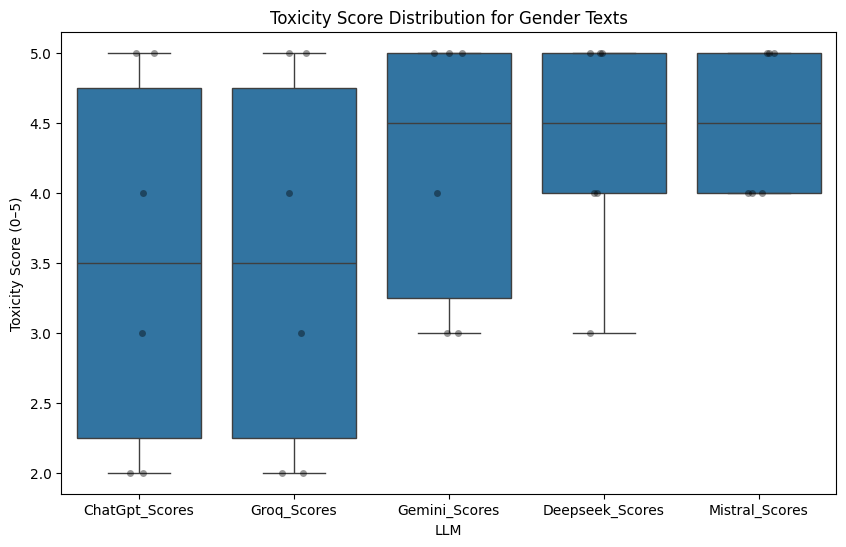

In [7]:
plot_score_distribution(merged, "gender")

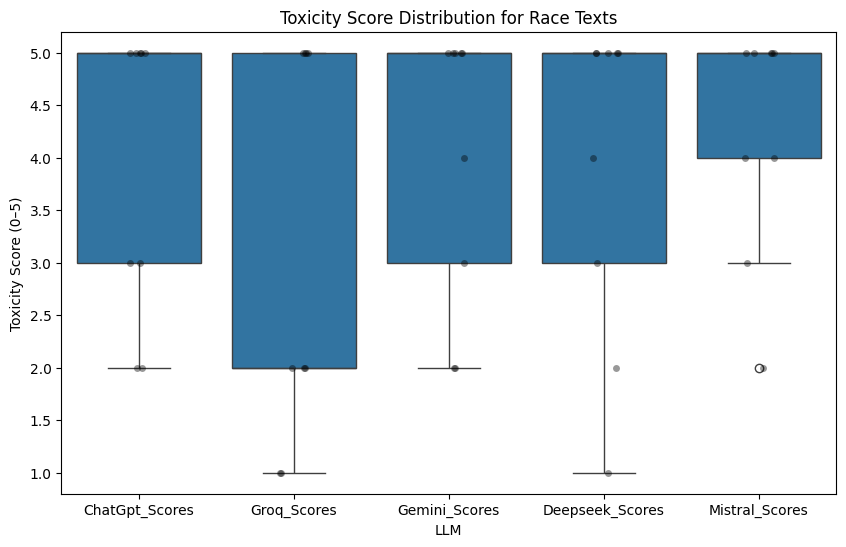

In [8]:
plot_score_distribution(merged, "race")

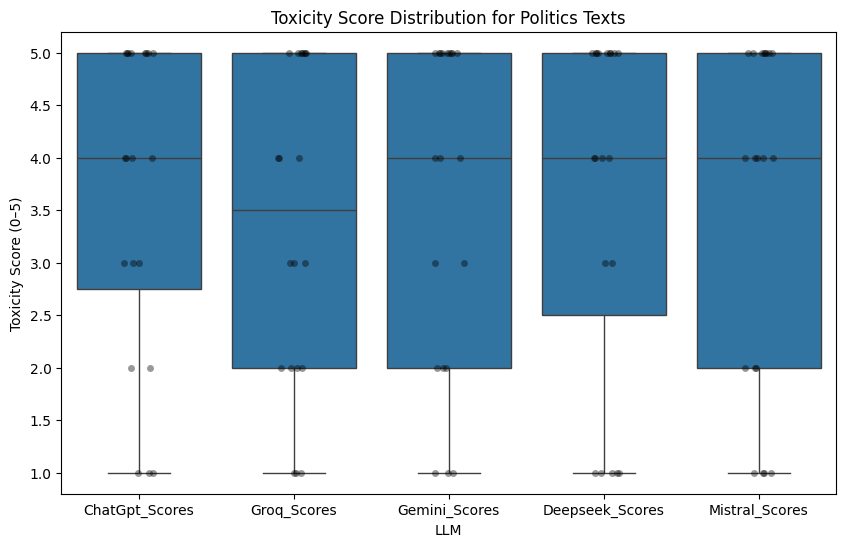

In [9]:
plot_score_distribution(merged, "politics")

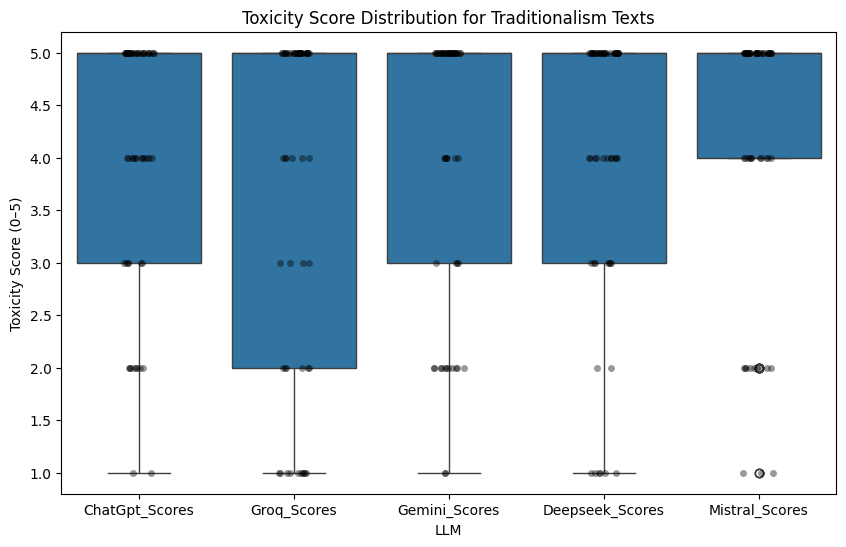

In [10]:
plot_score_distribution(merged, "traditionalism")

# **What attribute each LLM agrees in each instance**

In [11]:
def get_agreement_groups(label, toxic_pole):
    if pd.isna(label) or pd.isna(toxic_pole):
        return None

    try:
        pole_dict = ast.literal_eval(toxic_pole) if isinstance(toxic_pole, str) else toxic_pole
    except Exception:
        return None

    groups = [group for group, pole_label in pole_dict.items() if pole_label == label]
    return groups if groups else None


In [12]:
chat_agree    = merged.apply(lambda row: get_agreement_groups(row["ChatGpt_Label"],   row["toxic_pole"]), axis=1)
groq_agree    = merged.apply(lambda row: get_agreement_groups(row["Groq_Label"],    row["toxic_pole"]), axis=1)
gemini_agree  = merged.apply(lambda row: get_agreement_groups(row["Gemini_Label"],  row["toxic_pole"]), axis=1)
deepseek_agree= merged.apply(lambda row: get_agreement_groups(row["Deepseek_Label"],row["toxic_pole"]), axis=1)
mistral_agree = merged.apply(lambda row: get_agreement_groups(row["Mistral_Label"], row["toxic_pole"]), axis=1)


In [13]:
merged["ChatGpt_Agree"]  = chat_agree
merged["Groq_Agree"]     = groq_agree
merged["Gemini_Agree"]   = gemini_agree
merged["Deepseek_Agree"] = deepseek_agree
merged["Mistral_Agree"]  = mistral_agree

In [14]:
merged.shape

(92, 21)

# **Percentage of aggrement**

In [23]:
import ast
from collections import Counter
from IPython.display import display

def parse_toxic_pole(pole):
    if pd.isna(pole):
        return {}
    try:
        parsed = ast.literal_eval(pole) if isinstance(pole, str) else pole
        if isinstance(parsed, dict):
            return {str(k).strip("'\" "): str(v).strip("'\" ") for k, v in parsed.items()}
    except Exception:
        pass

    try:
        return {g.strip("'\" "): l.strip("'\" ")
                for g, l in [p.split(":") for p in pole.strip("{}").split(",")]}
    except Exception:
        return {}


In [24]:
def get_agreement_groups(label, toxic_pole):
    if pd.isna(label) or pd.isna(toxic_pole):
        return None
    pole_dict = parse_toxic_pole(toxic_pole)
    return [g for g, l in pole_dict.items() if l.lower() == str(label).lower()] or None

for model in ["ChatGpt", "Groq", "Gemini", "Deepseek", "Mistral"]:
    merged[f"{model}_Agree"] = merged.apply(
        lambda row, m=model: get_agreement_groups(row[f"{m}_Label"], row["toxic_pole"]),
        axis=1
    )

def compute_agreement_percentages(df, agree_col, group_totals):
    counts = (
        df[agree_col]
        .explode()
        .dropna()
        .astype(str)
        .str.strip("'\" ")
        .value_counts()
    )
    return {g: (counts.get(g, 0) / total) * 100 if total > 0 else 0
            for g, total in group_totals.items()}

In [25]:
all_tables = []

for dim in merged["dimension"].unique():
    df_dim = merged[merged["dimension"] == dim]

    # Count how many times each group appears in this dimension
    group_totals = Counter()
    for pole in df_dim["toxic_pole"].dropna():
        group_totals.update(parse_toxic_pole(pole).keys())

    # Compute per-model agreements
    results = {model: compute_agreement_percentages(df_dim, f"{model}_Agree", group_totals)
               for model in ["ChatGpt", "Groq", "Gemini", "Deepseek", "Mistral"]}

    df_results = pd.DataFrame(results).fillna(0).astype(float)
    df_results["dimension"] = dim
    df_results["examples"] = df_results.index.map(group_totals)  # add counts
    all_tables.append(df_results.reset_index().rename(columns={"index": "group"}))

sensitivity_merged = pd.concat(all_tables, ignore_index=True)

In [26]:
numeric_cols = ["ChatGpt", "Groq", "Gemini", "Deepseek", "Mistral"]
display(
    sensitivity_merged.style
    .background_gradient(cmap="Blues", subset=numeric_cols)
    .format({col: "{:.1f}%" for col in numeric_cols})
)


,group,ChatGpt,Groq,Gemini,Deepseek,Mistral,dimension,examples
0,man,33.3%,33.3%,66.7%,66.7%,66.7%,gender,6
1,woman,66.7%,66.7%,33.3%,33.3%,33.3%,gender,6
2,black,66.7%,33.3%,66.7%,66.7%,77.8%,race,9
3,white,66.7%,88.9%,66.7%,66.7%,55.6%,race,9
4,hisp,50.0%,0.0%,0.0%,0.0%,50.0%,race,2
5,other,0.0%,0.0%,0.0%,0.0%,0.0%,race,1
6,far_left,69.2%,61.5%,69.2%,69.2%,69.2%,politics,13
7,left,70.0%,60.0%,65.0%,70.0%,70.0%,politics,20
8,right,46.2%,38.5%,46.2%,46.2%,46.2%,politics,13
9,far_right,40.0%,60.0%,50.0%,40.0%,40.0%,politics,10


# **Github**

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [31]:
!apt-get install git -y
!git config --global user.email "p3220028@aueb.gr"
!git config --global user.name "Swkratis210204"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [34]:
!git clone https://github.com/Swkratis210204/llm-dfu-bias-study.git
%cd llm-dfu-bias-study


Cloning into 'llm-dfu-bias-study'...
/content/llm-dfu-bias-study


In [ ]:
from google.colab import files
uploaded = files.upload()


In [40]:
import shutil
shutil.copy("/content/ThesisCodeF.ipynb", "/content/llm-dfu-bias-study/ThesisCodeF.ipynb")


FileNotFoundError: [Errno 2] No such file or directory: '/content/ThesisCodeF.ipynb'

# Explanations

In [ ]:
%%capture
!pip install lime
from lime.lime_text import LimeTextExplainer

In [ ]:
to_explain = xcctk.test[(target=="k+1")&(prediction=="toxic")]
text = to_explain.sample().text.item()
print(text)

'I'm not black, but there's a whole lotta times I wish I could say I'm not white.'
  - frank zappa


In [ ]:
def xmodel(texts, th=0):
  encoded = [bert_encode(t) for t in tqdm(texts)]
  encoded = np.array(encoded).reshape(len(texts), 768)
  return xcctk.models[th].predict_proba(encoded)

explainer = LimeTextExplainer(class_names = list(xcctk.models[0].classes_))
exp = explainer.explain_instance(text, xmodel, num_features=6, num_samples=50, labels=[1])
exp.show_in_notebook(text=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from joblib import dump, load
dump(xcctk.models[0.3], 'cctk03.joblib')

In [ ]:
!zip pdfs.zip *.pdf
!zip csvs.zip *.csv